In [30]:
import sklearn
import netCDF4
import numpy as np
import matplotlib.pyplot as plt

In [4]:
temp_data = netCDF4.Dataset("data/erai_t2m_daily.nc")  # 'temp' as in 'temperature'

In [229]:
def get_fine_data(t):
    return np.array(temp_data.variables["t2m"][t, ::-1, :])

class Coarsener:
    def __init__(self, sep):
        self.sep = sep

    def coarsen(self, f_data):
        return f_data[::self.sep, ::self.sep]


class Plotter:
    @staticmethod
    def plot_data(data, cmap=plt.get_cmap('jet')):
        plt.pcolormesh(data, cmap=cmap)
        
    @classmethod
    def plot_diff(cls, p_data, f_data, cmap=plt.get_cmap('jet')):
        cls.plot_data(p_data - f_data, cmap=cmap)
     
def rms(p_data, f_data):
    return np.sqrt(np.sum((p_data - f_data) ** 2))

f_shape = get_fine_data(0).shape

In [240]:
# If this was a bit more clever it wouldn't need the sep passed to it, but this is much simpler to code!
class Interpolater:
    def __init__(self, sep):
        self.sep = sep
        
    @staticmethod
    def local_interpolater(interpolate_func):
        def local_interpolater_inner(self, c_data):
            return_data = np.empty(f_shape, dtype=np.float32)
            for y in range(f_shape[0]):
                for x in range(f_shape[1]):
                    return_data[y, x] = interpolate_func(self, x, y, c_data)
            return return_data
        return local_interpolater_inner

    def zero_func(self, x, y, c_data):
        if y % self.sep == 0 and x % self.sep == 0:  # Known data
            return c_data[y // self.sep, x // self.sep]
        else:
            return 0

    def mean_func(self, x, y, c_data):
        c_shape = c_data.shape
        prop_x = (x % self.sep) / self.sep
        prop_y = (y % self.sep) / self.sep
        return (
                (1 - prop_x) * (1 - prop_y) * c_data[y // self.sep, x // self.sep] + 
                prop_x       * (1 - prop_y) * c_data[y // self.sep, (1 + x // self.sep) % c_shape[1]] +        # x axis wraps around; this is
                (1 - prop_x) * prop_y       * c_data[min(c_shape[0] - 1, 1 + y // self.sep), x // self.sep] +  # a first approximation to that
                prop_x       * prop_y       * c_data[min(c_shape[0] - 1, 1 + y // self.sep), (1 + x // self.sep) % c_shape[1]]
               )

    separate_data = local_interpolater.__func__(zero_func)
    average_data = local_interpolater.__func__(mean_func)

In [235]:
sep = 4
fine_data = get_fine_data(0)
coarse_data = Coarsener(sep=sep).coarsen(fine_data)

averaged_data = Interpolater(sep=sep).average_data(coarse_data)
rms(averaged_data, fine_data)

402.56918

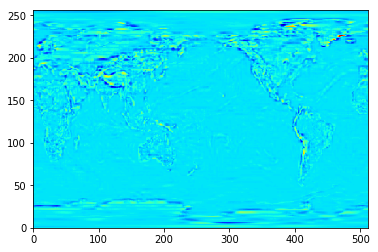

In [236]:
Plotter.plot_diff(averaged_data, fine_data)